In [25]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict as defaultdict

In [ ]:
env = gym.make('Blackjack-v1', sab = True)

def runBlackJack(env, runs, gamma, sampleMean, epsilon = 0.1, alpha = 0.1):
    Q = defaultdict(lambda : [0.0, 0.0])
    visits = defaultdict(lambda : [0, 0])
    
    policy = defaultdict(lambda : 1)

    for ace in (True, False):
        for dealer in range(1, 11):
            policy[(20, dealer, ace)] = 0
            policy[(21, dealer, ace)] = 0
    
    for _ in range(runs):
        
        state = env.reset()[0]
        episode = []
        
        action = env.action_space.sample()
        while True:
            # print(action)
            nextState, reward, terminated, x, y = env.step(action)
            episode.append((state, action, reward))
            
            if terminated:
                break
            
            state = nextState
            action = policy[state]
        
        episode.reverse()
        G = 0
        
        for state, action, reward in episode:
            G = gamma * G + reward
            
            visits[state][action] += 1
            if sampleMean:
                alpha = 1/visits[state][action]
            else:
                alpha = 0.1
            Q[state][action] += alpha * (G - Q[state][action])
            policy[state] = np.argmax(Q[state])
            
    return Q, policy

In [30]:
Q10, policy10 = runBlackJack(env, 1000000, 1, True)
Q50, policy50 = runBlackJack(env, 500000, 1, True)

In [31]:
import seaborn as sns
import matplotlib.patches as mpatches

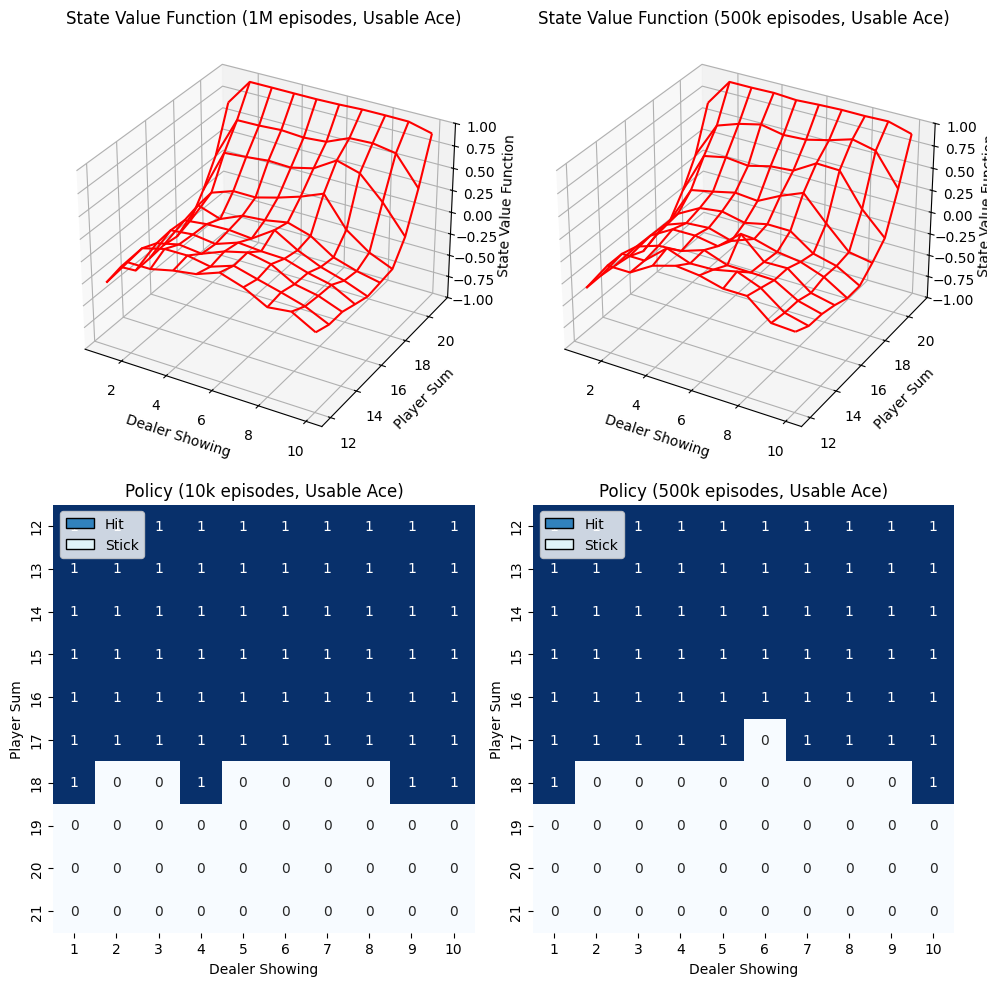

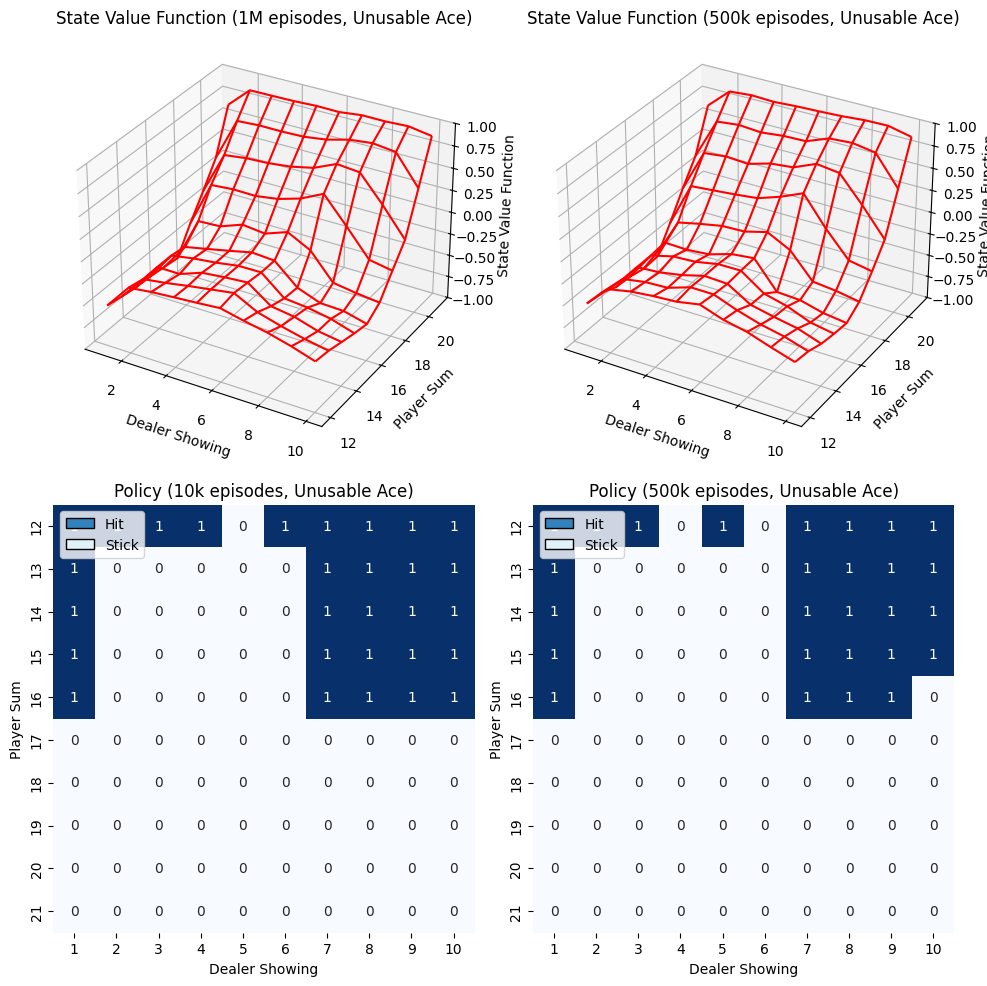

In [33]:
def plot_value_function(Q, title, ax, usable_ace):
    player_sums = np.arange(12, 22)
    dealer_sums = np.arange(1, 11)
    Z = np.zeros((len(player_sums), len(dealer_sums)))

    for i in range(len(player_sums)):
        player_sum = player_sums[i]
        for j in range(len(dealer_sums)):
            dealer_card = dealer_sums[j]
            state = (player_sum, dealer_card, usable_ace)
            if state in Q:
                Z[i, j] = max(Q[state])
            else:
                Z[i, j] = 0

    X, Y = np.meshgrid(dealer_sums, player_sums)
    ax.plot_wireframe(X, Y, Z, color='red')
    ax.set_zlim(-1, 1)
    ax.set_xlabel('Dealer Showing')
    ax.set_ylabel('Player Sum')
    ax.set_zlabel('State Value Function')
    ax.set_title(title)

def plot_policy(Q, title, ax, usable_ace):
    player_sums = np.arange(12, 22)
    dealer_sums = np.arange(1, 11)
    Z = np.zeros((len(player_sums), len(dealer_sums)))

    for i in range(len(player_sums)):
        player_sum = player_sums[i]
        for j in range(len(dealer_sums)):
            dealer_card = dealer_sums[j]
            state = (player_sum, dealer_card, usable_ace)
            if state in Q:
                Z[i, j] = np.argmax(Q[state])
            else:
                Z[i, j] = 0

    sns.heatmap(Z, linewidth=0, annot=True, cmap="Blues", cbar=False, ax=ax)
    ax.set_xticklabels(dealer_sums)
    ax.set_yticklabels(player_sums)
    ax.set_xlabel('Dealer Showing')
    ax.set_ylabel('Player Sum')
    ax.set_title(title)

    legend_elements = [
        mpatches.Patch(facecolor='#3182bd', edgecolor='black', label='Hit'),
        mpatches.Patch(facecolor='#e0f3f8', edgecolor='black', label='Stick'),
    ]
    ax.legend(handles=legend_elements, loc='upper left')

def plot_blackjack_results(Q1, Q2, usable_ace, ace_type):
    fig = plt.figure(figsize=(10, 10))
    
    plot_value_function(Q1, f'State Value Function (1M episodes, {ace_type} Ace)', fig.add_subplot(221, projection='3d'), usable_ace)
    plot_value_function(Q2, f'State Value Function (500k episodes, {ace_type} Ace)', fig.add_subplot(222, projection='3d'), usable_ace)

    plot_policy(Q1, f'Policy (10k episodes, {ace_type} Ace)', fig.add_subplot(223), usable_ace)
    plot_policy(Q2, f'Policy (500k episodes, {ace_type} Ace)', fig.add_subplot(224), usable_ace)

    plt.tight_layout()
    plt.show()

plot_blackjack_results(Q10, Q50, usable_ace=True, ace_type="Usable")
plot_blackjack_results(Q10, Q50, usable_ace=False, ace_type="Unusable")